## Treci domaci zadatak

### Nikolina Bunijevac
### 2017/0017


In [57]:
from __future__ import print_function

%matplotlib inline
import scipy
import imageio
from pylab import *
import cv2
import skvideo.io
import os


import ipywidgets as widgets

import skimage
from skimage import *
from skimage.color import *
from skimage.exposure import *
from skimage.filters import *
from skimage.morphology import disk
from skimage import io
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import line

import numpy as np
import numpy.matlib

from scipy import ndimage

import time


In [2]:
def segment_lanes(img_in):
    """
    segment_lanes: funkcija koja iz ulazne slike izdvaja segment slike u kojem se nalaze linije 
                   koje razdvajaju saobraćajne trake
    
    Ulazni paramterni funkcije:
        - img_in: ulazna slika

    Izlaz funkcije:
        - img_out: izlazna slika
    """
    
    img_hsv = rgb2hsv(img_in);
    img_h = img_hsv[:,:,0];
    img_s = img_hsv[:,:,1];
    img_v = img_hsv[:,:,2];
    
    mask_yellow = (img_h < 0.4) & (img_s > 0.5) & (img_v > 0.65) 
    mask_white = (img_h < 0.2) & (img_s < 0.1) & (img_v > 0.8)
    
    # maske pre kropovanja
    mask_yellow_old = mask_yellow.copy()
    mask_white_old = mask_white.copy()
    
    # praticemo zutu liniju i kropovati belu masku
    [M,N] = shape(img_in[:,:,0])
    start = 0
    wide = 30
    flag = False
    mask = zeros(shape(mask_yellow))
    mask[mask_yellow] = 1; 
    for i in range(M-1,-1,-3):
        if(flag == True):
            wide = wide-1;
        if(max(mask[i,:].flatten())>0 and flag == False):
            flag = True;
        if(sum(mask[i,:].flatten())<5 and flag == True and wide<0):
            start = i + 5;
            break;  
    
    mask_yellow[0:start,:] = False
    mask_white[0:start,:] = False
       
    flag_left = False;
    start_left = 0;
    for i in range(0,N):
        if((flag_left == False) and (max(mask[:,i].flatten()) > 0)):
            start_left = i;
            flag_left = True;
            break
    
    mask_white[:,0:start_left] = False
    mask_yellow[:,0:start_left] = False

    mask = mask*0
    mask[mask_white] = 1
    mask[mask_yellow] = 1

    
    return mask_white_old,mask_yellow_old,mask_white,mask_yellow,mask

#### Ucitavanje slika

In [3]:
img1 = img_as_float(imread('.\sekvence\\test1.jpg'))
img2 = img_as_float(imread('.\sekvence\\test2.jpg'))
img3 = img_as_float(imread('.\sekvence\\test3.jpg'))
img4 = img_as_float(imread('.\sekvence\\test4.jpg'))
img5 = img_as_float(imread('.\sekvence\\test5.jpg'))
img6 = img_as_float(imread('.\sekvence\\test6.jpg'))

In [4]:
[white_old_1,yellow_old_1,white_1,yellow_1,mask_1] = segment_lanes(img1)
[white_old_2,yellow_old_2,white_2,yellow_2,mask_2] = segment_lanes(img2)
[white_old_3,yellow_old_3,white_3,yellow_3,mask_3] = segment_lanes(img3)
[white_old_4,yellow_old_4,white_4,yellow_4,mask_4] = segment_lanes(img4)
[white_old_5,yellow_old_5,white_5,yellow_5,mask_5] = segment_lanes(img5)
[white_old_6,yellow_old_6,white_6,yellow_6,mask_6] = segment_lanes(img6)

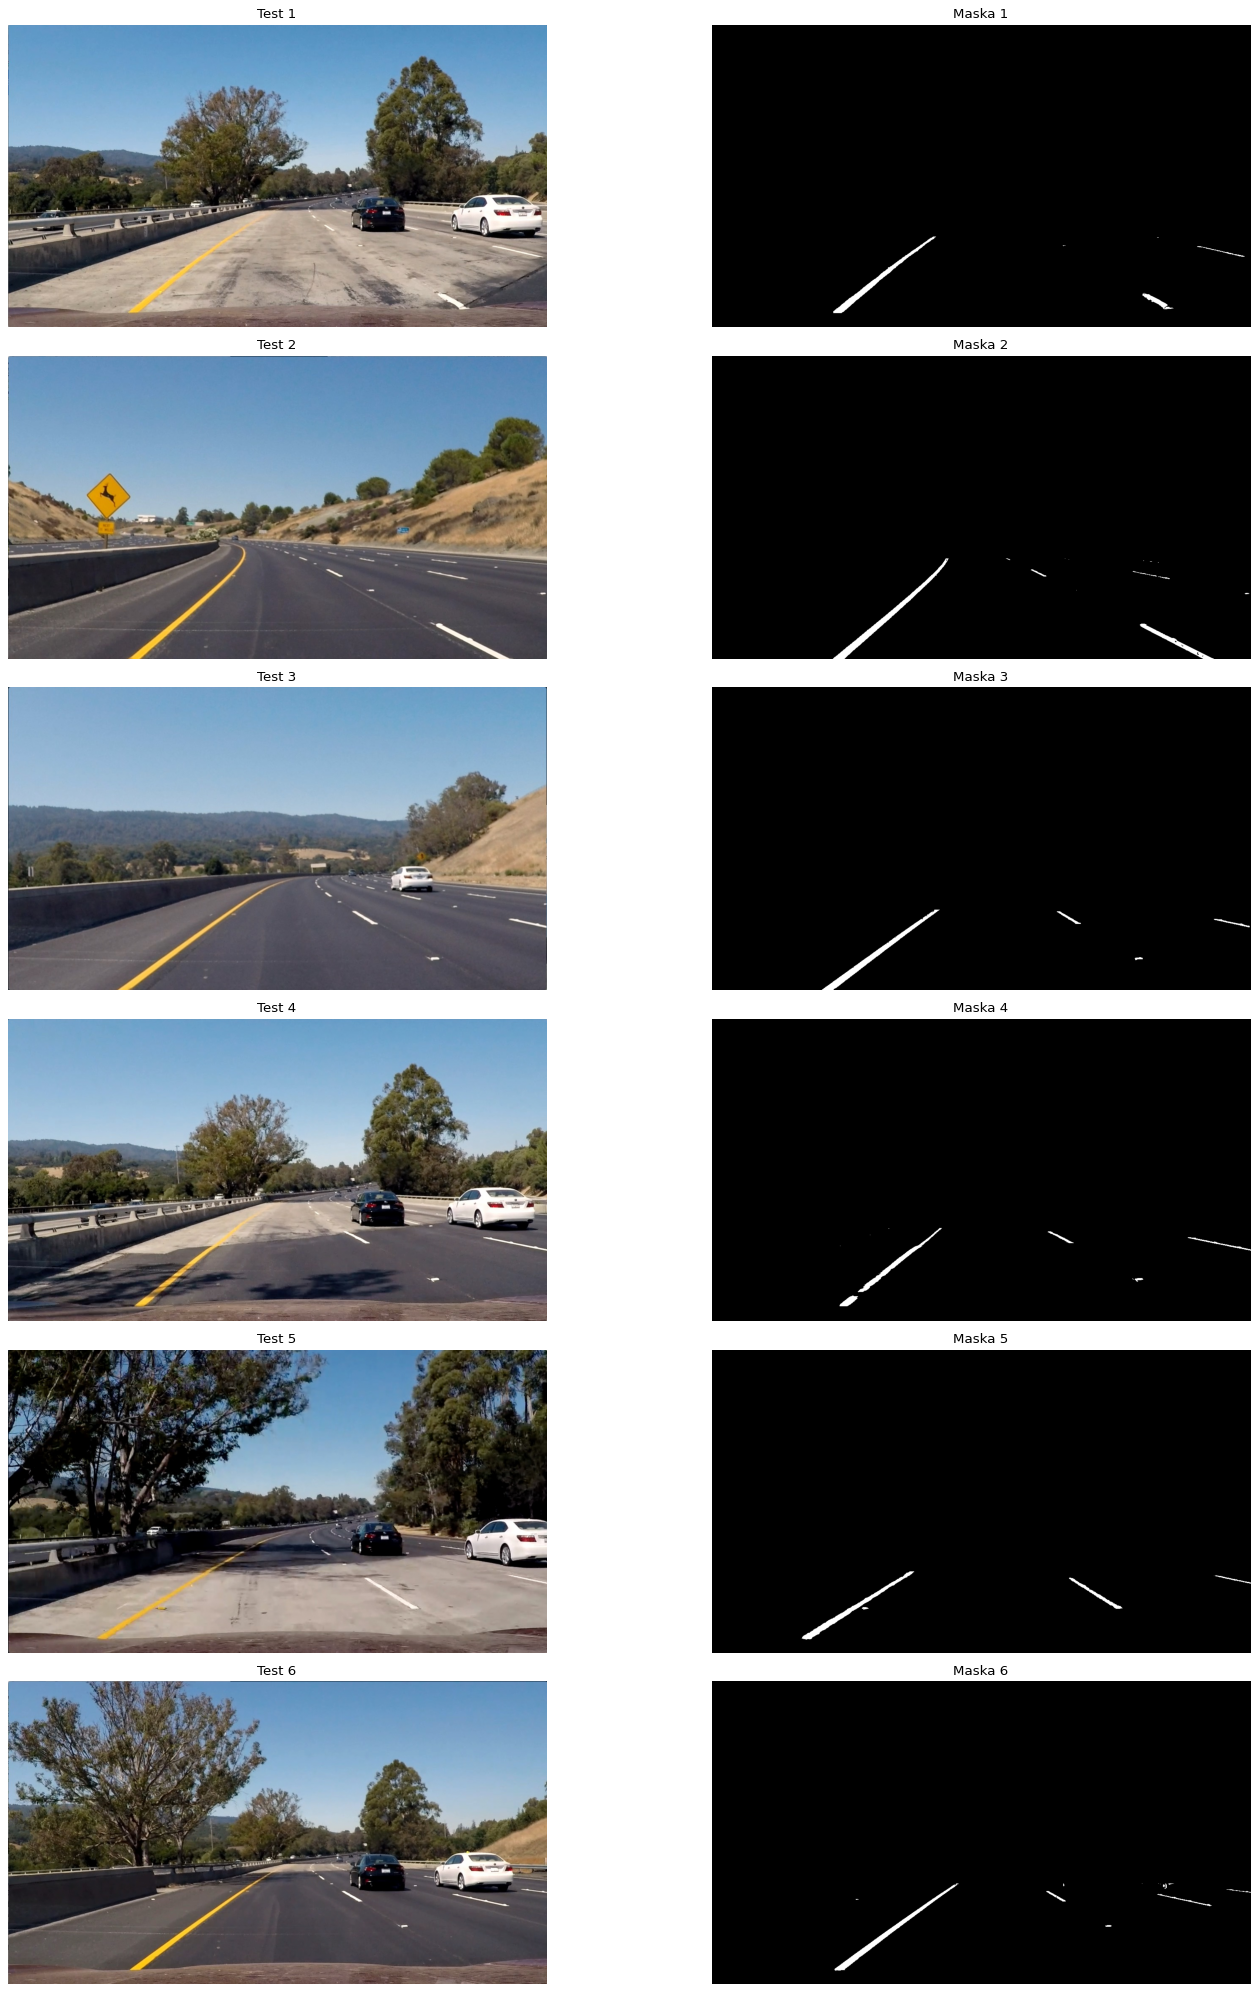

In [6]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(20,25), dpi=80)

axes[0,0].imshow(img1, vmin=0, vmax=1); axes[0,0].set_axis_off();
axes[0,1].imshow(mask_1, cmap='gray'); axes[0,1].set_axis_off();
axes[0,0].set_title('Test 1'); axes[0,1].set_title('Maska 1')

axes[1,0].imshow(img2, vmin=0, vmax=1); axes[1,0].set_axis_off();
axes[1,1].imshow(mask_2, cmap='gray'); axes[1,1].set_axis_off();
axes[1,0].set_title('Test 2'); axes[1,1].set_title('Maska 2')

axes[2,0].imshow(img3, vmin=0, vmax=1); axes[2,0].set_axis_off();
axes[2,1].imshow(mask_3, cmap='gray'); axes[2,1].set_axis_off();
axes[2,0].set_title('Test 3'); axes[2,1].set_title('Maska 3')

axes[3,0].imshow(img4, vmin=0, vmax=1); axes[3,0].set_axis_off();
axes[3,1].imshow(mask_4, cmap='gray'); axes[3,1].set_axis_off();
axes[3,0].set_title('Test 4'); axes[3,1].set_title('Maska 4')

axes[4,0].imshow(img5, vmin=0, vmax=1); axes[4,0].set_axis_off();
axes[4,1].imshow(mask_5, cmap='gray'); axes[4,1].set_axis_off();
axes[4,0].set_title('Test 5'); axes[4,1].set_title('Maska 5')

axes[5,0].imshow(img6, vmin=0, vmax=1); axes[5,0].set_axis_off();
axes[5,1].imshow(mask_6, cmap='gray'); axes[5,1].set_axis_off();
axes[5,0].set_title('Test 6'); axes[5,1].set_title('Maska 6')


plt.tight_layout()
plt.show()

### Na prethodnim slikama prikazane su test slike i izlazi nakon segmentacije. Vidimo da su uglavnom detektovane samo zeljenje saobracajne trake, tek ponegde se vide obrisi belog automobila, ali oni ce kasnije biti potisnuti.

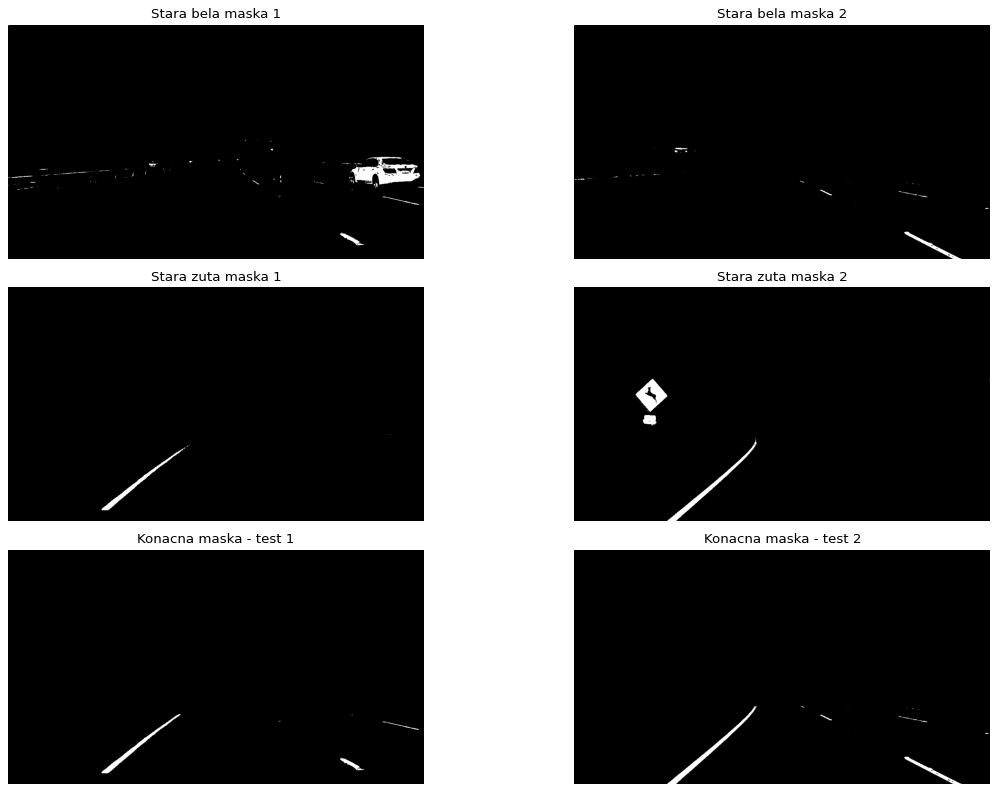

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(16,10), dpi=80)

axes[0,0].imshow(white_old_1, cmap='gray'); axes[0,0].set_axis_off();
axes[1,0].imshow(yellow_old_1, cmap='gray'); axes[1,0].set_axis_off();
axes[2,0].imshow(mask_1, cmap='gray'); axes[2,0].set_axis_off();
axes[0,0].set_title('Stara bela maska 1'); 
axes[1,0].set_title('Stara zuta maska 1')
axes[2,0].set_title('Konacna maska - test 1')

axes[0,1].imshow(white_old_2, cmap='gray'); axes[0,1].set_axis_off();
axes[1,1].imshow(yellow_old_2, cmap='gray'); axes[1,1].set_axis_off();
axes[2,1].imshow(mask_2, cmap='gray'); axes[2,1].set_axis_off();
axes[0,1].set_title('Stara bela maska 2'); 
axes[1,1].set_title('Stara zuta maska 2')
axes[2,1].set_title('Konacna maska - test 2')


plt.tight_layout()
plt.show()

### U prvoj koloni nalaze se za test 1: prvobitna bela maska, prvobitna zuta maska i konacna maska. U drugoj koloni isto to za test 2. Segmentacija je odradjena tako da se prati zuta traka - s leve strane pre zute trake sve ce biti odseceno, kao i iznad poslednje tacke zute trake. Moze se desiti da se bela maska previse odsece - zato postoji uslov da ako do toga dodje, stara bela maska bude ipak uzeta kao validna.

In [68]:
def sobel_filters(img):
    """
    sobel_filter: funkcija koja iz ulazne slike izdvaja gradijent
                  2. korak u detekciji ivica kanijevim algoritmom
    
    Ulazni paramterni funkcije:
        - img: ulazna slika

    Izlaz funkcije:
        - G: amplituda gradijenta - od 0 do 1
        - theta: ugao gradijenta u stepenima
    """
    
    Kx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]) # normalizovana je yaaas
    Ky = np.transpose(Kx)    
    
    Gx = ndimage.correlate(img, Kx, mode='nearest') 
    Gy = ndimage.correlate(img, Ky, mode='nearest') 
    
    G = np.sqrt(np.square(Gx) + np.square(Gy))
    theta = np.arctan2(Gy, Gx)
    theta = np.rad2deg(theta)

    
    return (G, theta)

In [69]:
def non_max_suppression(grad_magn, angle):
    """
    non_max_suppression: funkcija koja na osnovu ulaznih parametara izdvaja
                         piksele sa maksimalnim intenzitetom gradijenta po 
                         svakom pravcu
                         3. korak u detekciji ivica kanijevim algoritmom       
    
    Ulazni paramterni funkcije:
        - mag: magnituda gradijenta - od 0 do 1
        - angle_rad: ugao gradijenta u stepenima

    Izlaz funkcije:
        - Z: jedinicne ivice
    """   
    
    [M,N] = angle.shape
    edges = np.zeros(angle.shape)
    
    # razmatramo pravce po uglu 0,45,90 i -45 stepeni
    # u zavisnosti od pravca, izdvajamo okruzenje posmatranog piksela
    # i setujemo promenljivu surrounding na maksimum okruzenja
    
    # iteracijom ne moramo obuhvatiti rubove slike jer na njima nema ivica
    
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            # angle = 45
            if ((angle[i,j] >= 22.5) and (angle[i,j] < 67.5)): 
                surrounding = max(grad_magn[i - 1, j - 1], grad_magn[i + 1, j + 1])
            # angle = - 45
            elif ((angle[i,j] >= -67.5) and (angle[i,j] < -22.5)):
                surrounding = max(grad_magn[i + 1, j - 1], grad_magn[i - 1, j + 1])
            # angle = 0
            elif ((angle[i,j] >= -22.5) and (angle[i,j] <22.5)): 
                surrounding = max(grad_magn[i + 1, j], grad_magn[i - 1, j])
            # angle = 90
            else:
                surrounding = max(grad_magn[i, j - 1], grad_magn[i, j + 1])
                
            # ako je posmatrani px najveci u okruzenju, upisujemo njegov intenzitet
            # u izlaznu matricu, a ako nije, na njegovom mestu je vec 0          
            if grad_magn[i, j] >= surrounding:
                edges[i, j] = grad_magn[i, j]
                
    return edges

In [7]:
def threshold(grad, low_threshold=0.05, high_threshold=0.09):
    """
    non_max_suppression: funkcija koja na ulaznu matricu ivica poredi sa 
                         zadatim pragovima i odredjuje koje su ivice slabe,
                         a koje jake
                         4. korak u detekciji ivica kanijevim algoritmom
            
    
    Ulazni paramterni funkcije:
        - grad: magnituda gradijenta nakon non-max-suppresion, od 0 do 1
        - low_threshold: 
        - high_threshold:

    Izlaz funkcije:
        - edges: mapa ivica
        - value_weak: vrednost slabih ivica
        - value_strong: vrednost slabih ivica
    """   

    value_weak = 0.5
    value_strong = 1
    # prvo sve setujemo na slabe ivice
    edges = np.zeros_like(grad) + value_weak
    # px vece od gornje granice stvrstavamo u jake
    edges[grad>=high_threshold] = value_strong
    # manje od donje ponistavamo
    edges[grad<=low_threshold] = 0
    
   
    return (edges, value_weak, value_strong)

In [8]:
def hysteresis(edges, weak, strong):
    """
    hysteresis: funkcija koja povezuje slabe ivice setuje na jake ako se 
                u njihovom okruzenju nalaze jake ivice
                5. korak u detekciji ivica kanijevim algoritmom             
    
    Ulazni paramterni funkcije:
        - edges: mapa jakih i slabih ivica
        - weak: vrednost slabih ivica
        - strong: vrednost slabih ivica

    Izlaz funkcije:
        - edges: konacna mapa ivica
    """   
    
    M, N = edges.shape  
    
    flag = True
    while(flag == True):
        flag = False
        for i in range(1, M-1):
            for j in range(1, N-1):
                if (edges[i,j] == weak):
                        # ako se u okruzenju posmatranog px slabe ivice nalazi
                        # bar jedan px jake ivice, on postaje deo te ivice
                        if (max(edges[i-1:i+2,j-1:j+2].flatten())==strong):
                            edges[i, j] = strong
                            flag = True
    
    edges[edges<strong] = 0
                            
    return edges

In [65]:
def canny_edge_detection(img_in,sigma_in,lowT,highT):
    """
    canny_edge_detection: funkcija koja detektuje ivice na ulaznoj slici
    
    Ulazni paramterni funkcije:
        - img_in: ulazna slika, jednoslojna
        - sigma: ulazni parametar za gausov filtar
        - lowT: ulazni parametar za korak treshold
        - highT: ulazni parametar za korak treshold

    Izlaz funkcije:
        - edges: konacna mapa ivica
    """   
    
    # dimenzije slike
    [M,N] = shape(img_in)

    # filtriranje - potiskuje se sum 
    img_filt = gaussian(img_in, sigma=sigma_in, mode='nearest', truncate=3)

    # sobelov operator - izracunava se gradijent - magnituda i ugao
    Grad,angle = sobel_filters(img_filt)

    # potiskivanje ne-maksimuma duz pravca dominantnog gradijenta kako 
    # bi se dobile jedinicne ivice
    Grad_nonmax = non_max_suppression(Grad,angle) 

    # klasifikovanje detektovanih ivica na slabe, jake i sum
    [edges,weak_l,strong_l] = threshold(Grad_nonmax,lowT,highT)
    
    # povezivanje slabih ivica sa susednim jakim, ako ih ima
    img_out = hysteresis(edges,weak_l,strong_l)

    
    return img_out
    

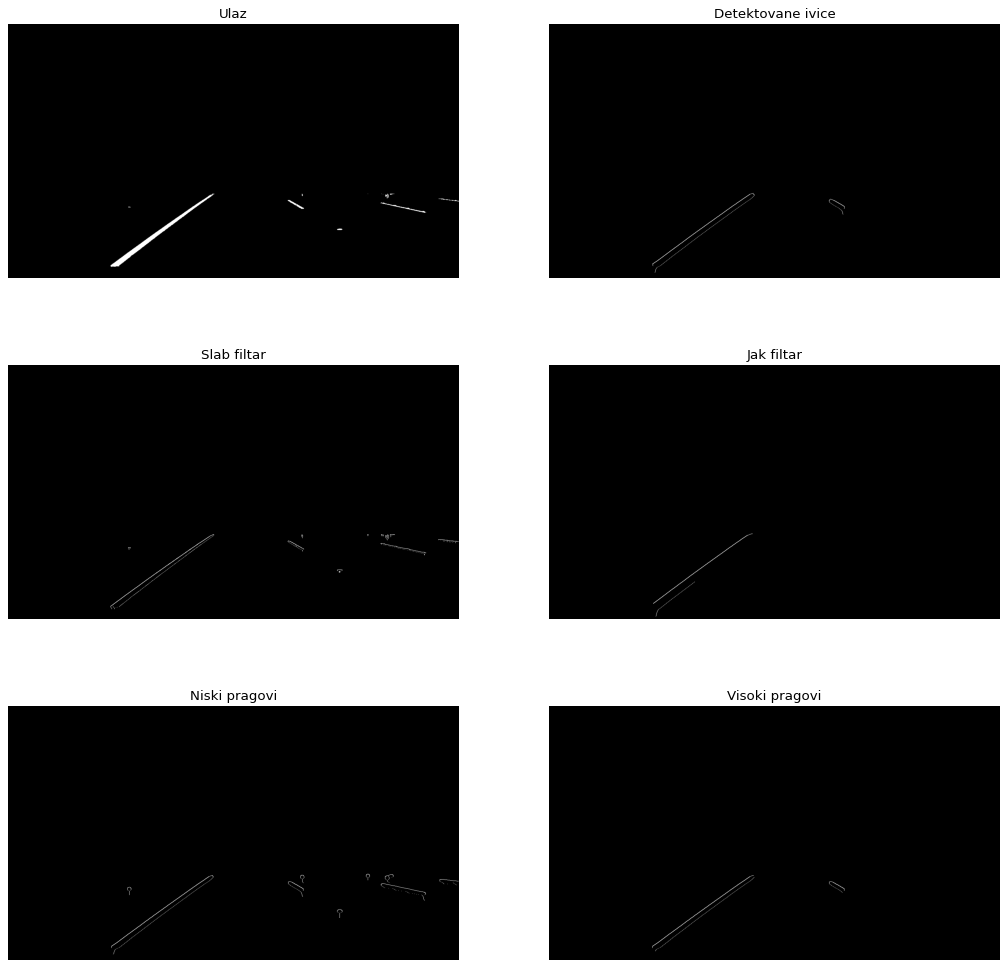

In [45]:
img6_edges = canny_edge_detection(mask_6,6,0.01,0.2)

img6_edges_weak_gauss = canny_edge_detection(mask_6,1,0.01,0.2)
img6_edges_strong_gauss = canny_edge_detection(mask_6,10,0.01,0.2)
img6_edges_low_tresholds = canny_edge_detection(mask_6,5,0.001,0.002)
img6_edges_high_tresholds = canny_edge_detection(mask_6,5,0.2,0.25)

fig, ax=plt.subplots(nrows = 3, ncols=2, figsize=(16,16), dpi=80)
ax = ax.ravel()

ax[0].imshow(mask_6, cmap='gray'); ax[0].set_title('Ulaz'); 
ax[1].imshow(img6_edges, cmap='gray'); ax[1].set_title('Detektovane ivice'); 
ax[2].imshow(img6_edges_weak_gauss, cmap='gray'); ax[2].set_title('Slab filtar'); 
ax[3].imshow(img6_edges_strong_gauss, cmap='gray'); ax[3].set_title('Jak filtar'); 
ax[4].imshow(img6_edges_low_tresholds, cmap='gray'); ax[4].set_title('Niski pragovi'); 
ax[5].imshow(img6_edges_high_tresholds, cmap='gray'); ax[5].set_title('Visoki pragovi'); 
ax[0].set_axis_off(); ax[1].set_axis_off(); ax[2].set_axis_off();
ax[3].set_axis_off(); ax[4].set_axis_off(); ax[5].set_axis_off();


plt.show()

### Na prethodnim slikama mozemo da uocimo uticaj ulaznih parametara za detekciju ivica kanijevim algoritmom. Slab filtar (malo sigma - manje usrednjavanje) ne potisne dovoljno slucajne ivice. Prejak filtar dosta potisne sum i slabe ivice, cak i one ivice od interesa. Niski pragovi u koraku kada se odredjuju slabe i jake ivice ce i sumove detektovati kao jake ivice, dok ce visoki pragovi zadrzati samo najjace ivice. 

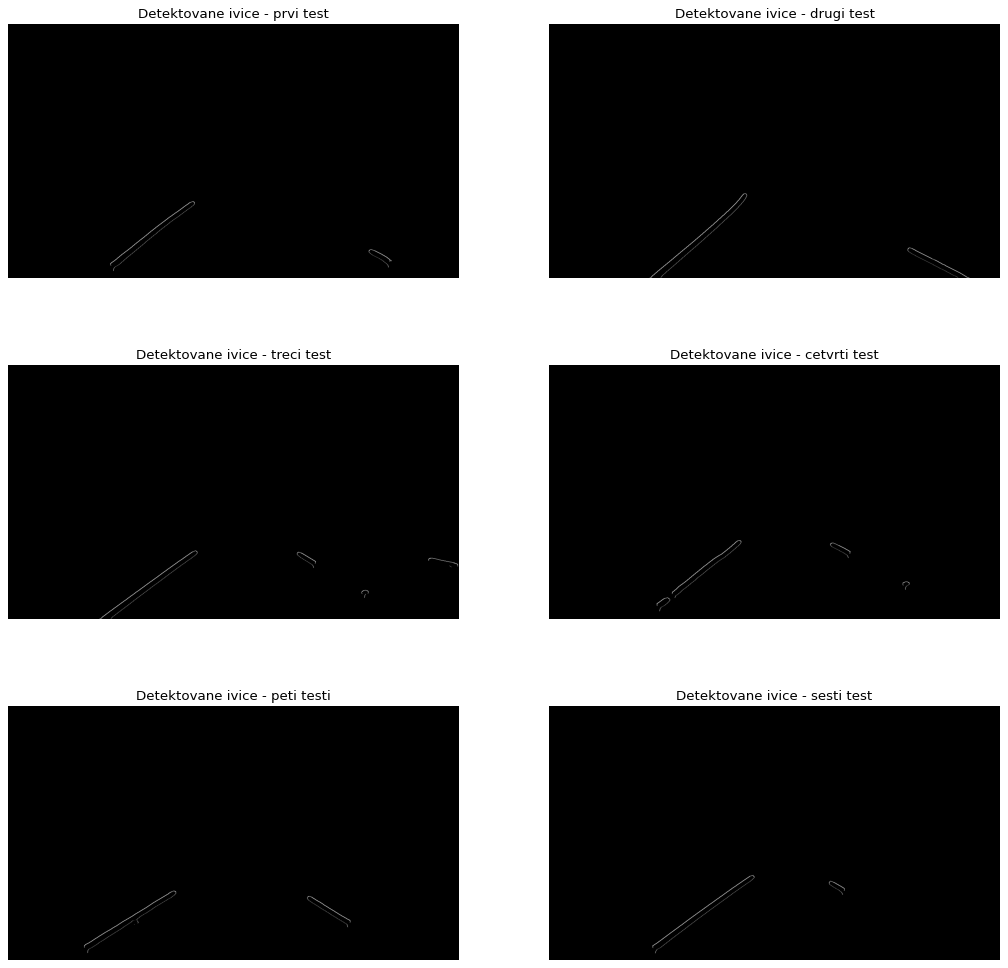

In [52]:
img1_edges = canny_edge_detection(mask_1,6,0.05,0.2)
img2_edges = canny_edge_detection(mask_2,6,0.05,0.2)
img3_edges = canny_edge_detection(mask_3,6,0.05,0.2)
img4_edges = canny_edge_detection(mask_4,6,0.05,0.2)
img5_edges = canny_edge_detection(mask_5,6,0.05,0.2)
img6_edges = canny_edge_detection(mask_6,6,0.05,0.2)


fig, ax=plt.subplots(nrows = 3, ncols=2, figsize=(16,25), dpi=80)
ax = ax.ravel()

ax[0].imshow(img1_edges, cmap='gray'); ax[0].set_title('Detektovane ivice - prvi test'); 
ax[1].imshow(img2_edges, cmap='gray'); ax[1].set_title('Detektovane ivice - drugi test'); 
ax[2].imshow(img3_edges, cmap='gray'); ax[2].set_title('Detektovane ivice - treci test'); 
ax[3].imshow(img4_edges, cmap='gray'); ax[3].set_title('Detektovane ivice - cetvrti test'); 
ax[4].imshow(img5_edges, cmap='gray'); ax[4].set_title('Detektovane ivice - peti testi'); 
ax[5].imshow(img6_edges, cmap='gray'); ax[5].set_title('Detektovane ivice - sesti test'); 
ax[0].set_axis_off(); ax[1].set_axis_off(); ax[2].set_axis_off();
ax[3].set_axis_off(); ax[4].set_axis_off(); ax[5].set_axis_off();


plt.show()

### Za 6 test slika prikazane su detektovane ivice za parametre kanijevog algoritma: sigma = 6, donja granica = 0.05 i gornja granica = 0.2

In [54]:
def get_line_segments(img_edges,line,min_size,max_gaps,tolerancy):
    """
    get_line_segments: funkcija koja na zadatoj slici sa ivicnim pikselima detektuje duzi 
                       odgovarajuce duzine na zadatom pravcu
    
    Ulazni paramterni funkcije:
        - img_edges: slika sa detektovanim ivičnim pikselima
        - line: niz od dva elementa (theta, ro) kojim se zadaje pravac linije u normalnoj 
                reprezentaciji
        - min_size: miniminalna duzina duzi (u pikselima)
        - max_gaps: maksimalne veličine prekida (u pikselima) koje se mogu ignorisati 
                    prilikom detekcije duzi
        - tolerancy: radijus okoline u okviru koje se traže ivični pikseli

    Izlaz funkcije:
        - line_segments – niz detektovanih duži pri čemu je svaka duž predstavljena sa 
                          koordinatama početne i krajnje tačke duži
    """   
    
    [M,N] = np.shape(img_edges)
    ro = line[0]
    theta = line[1]
 
    dots = []
    
    y_coord, x_coord = np.where(img_edges > 0)
    # prolazimo kroz sve ivice i proveravamo da li one pripradaju zadatoj pravoj,
    # uz dozvoljeno unapred odredjeno odstupanje - tolerancy
    for i in range(0,len(x_coord)):
        if (abs(x_coord[i]*np.cos(theta)+y_coord[i]*np.sin(theta) - ro) < tolerancy):
            dots.append([x_coord[i],y_coord[i]])
    
    if (len(dots) < 2): 
        # ako nema dovoljno detektovanih tacaka, vracamo nazad praznu listu
        return []
    else:
        # provera da li izdvojene tacke zadovoljavaju potrebne kriterijume
        line_segments = []
        dots = np.array(dots)
        first = dots[0] 
        for i in range(1,len(dots)):
            
            # provera da li je gap preveliki
            if(np.linalg.norm(dots[i] - dots[i-1]) > max_gaps):
                # ako je praznina prevelika, zaustavljamo se na prethodnoj
                # pamtimo ako duz je duz veca od minimalne duzine 
                if (np.linalg.norm(first - dots[i-1]) > min_size):
                    line_segments.append([first,dots[i-1]])
                # nova duz pocinje na trenutno posmatranoj tacki
                first = dots[i] 
                continue

        if not line_segments: 
            # ako je lines prazna lista, znaci da su sve tacke do sad na istom pravcu, 
            # odgovarajuceg rastojanja, pa su pocetak i kraj duzi prva i poslednja tacka 
            # na ovom pravcu 
            line_segments.append([first,dots[len(dots)-1]])
       
        return line_segments


### Sto se tice detekcija leve i desne saobracajne trake, funkciju get_line_segments zovemo sa razlicitim parametrima za levu i desnu saobracajnu traku. Duz za levu traku je detektovana obicno bez problema, s obzirom na to da se lakse i bolje segmentise. Ugao koji prvo pretpostavimo je pozitivan ugao i velika distanca za hafovu funkciju, za cije cemo povratne vrednosti naci medijanu i to ce biti parametri za funkciju get_line_segments. Minimalna duzina koju zahtevamo ce biti 30, praznine 150 (ne ocekujemo ih previse), a tolerancija 10. Ako je ne nadjemo, posluzicemo se parametrima iz prethodne iteracije, jer ne ocekujemo velike promene za mali pomeraj u vremenu, a moguce je da senka onemogucava odgovarajucu segmentaciju, pa samim tim ni detekciju duzi. 
### Za desnu traku potrebno je vise iteracija i slucajeva. Prvo pretpostavimo ugao oko -60 stepeni, i ne prevelike distance. Parametri kojima zovemo funkciju get_line_segments su redom: 5,450,10 -> dakle ne zahtevamo dugacke linije jer smo svesniji losije segmentacije, a dozvoljavamo dosta vece praznine jer je u pitanju isprekidana traka. Beli automobil moze da pravi problem, pa je za slucaj neuspesne prethodne detekcije moguce hafovom funkcijom vratiti 100 pikova, a iz njih trazimo odgovarajuce. Ukoliko je prethodni frejm dostupan, ogranicice ugao i distancu desne trake narednog frejma, jer ne ocekujemo prevelike oscilacije. Ukoliko i nakon vise grana ne budu nadjene tacke za desnu traku, prepisace se iz prosle iteracije. 

In [55]:
# inicijalizacija vrednosti koje ce biti parametri
# prethodnih iteracija, za slucaj da funkcija ne nadje
# odgovarajuce prave i tacke u tekucoj iteraciji
ro_r_prev = 10000
theta_r_prev = 10000
duzi_r_prev = []
duzi_l_prev = []

def lane_detection(frame):
    """
    lane_detection: funkcija koja na zadatoj slici nalazi za levu i desnu saobracajnu liniju 
                    trake kojom se kola krecu odgovarajuce gornje i donje tacke
    
    Ulazni paramterni funkcije:
        - frame: trenutna slika koju je potrebno obraditi


    Izlaz funkcije:
        - [duzi_r[0],duzi_r[len(duzi_r)-1]]: desna duz, sa dve tacke koje je definisu,
        - [duzi_l[0],duzi_l[len(duzi_l)-1]]: leva duz, sa dve tacke koje je definisu
    """  
    
    # neophodno je navesti globalne promenljive
    global ro_r_prev
    global theta_r_prev
    global duzi_r_prev
    global duzi_l_prev
    
    # izdvajanje ivica iz ulazne slike
    _,_,_,_,out = segment_lanes(frame)
    img_edges = canny_edge_detection(out,6,0.05,0.2)

    # inicijalizacija parametara
    ro_r = 0
    theta_r = 0
    theta_r_vector = []
    ro_r_vector = []
    ro_l = 0
    theta_l = 0
    num = 0

    
    # *************************************************************************** 
    # _______________________________ DESNA TRAKA _______________________________
    
    # prva iteracija, kad nemamo prethodnika
    if (theta_r_prev == 10000):
        
        # okvirno ocekujemo desnu traku u ovom rasponu uglova (empirijski dobijeno)
        theta_ = np.linspace(-np.pi/2.9,-np.pi/3.7,360,endpoint = True)
        [out,angles,distances] = hough_line(img_edges,theta = theta_)
        [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=5)


        for angle,dist in zip(peak_angles,peak_distances):
            if dist<200 and dist>-350:
                num+=1
                theta_r_vector.append(angle)
                ro_r_vector.append(dist)
        if num > 0:
            theta_r = np.median(theta_r_vector)
            ro_r = np.median(ro_r_vector)
            duzi_r = get_line_segments(img_edges,[ro_r,theta_r],5,450,10) #dots_r, dots_l u obliku x dole , max gaps bio 450

        else:
            duzi_r = []
            ro_r_vector.clear()
            theta_r_vector.clear()
            # slucaj kada nam je slaba desna traka
            [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=100) 
            for angle,dist in zip(peak_angles,peak_distances):
                if dist<200 and dist>-350:
                    num+=1
                    theta_r_vector.append(angle)
                    ro_r_vector.append(dist)

            if num > 0:
                theta_r = np.median(theta_r_vector)
                ro_r = np.median(ro_r_vector)
                duzi_r = get_line_segments(img_edges,[ro_r,theta_r],5,450,10) #dots_r, dots_l u obliku x dole , max gaps bio 450



            if not duzi_r:
                ro_r_vector.clear()
                theta_r_vector.clear()

                for angle,dist in zip(peak_angles,peak_distances):
                    if dist<0 and dist>-350:
                        num+=1
                        theta_r_vector.append(angle)
                        ro_r_vector.append(dist)

                if num > 0:
                    theta_r = np.median(theta_r_vector)
                    ro_r = np.median(ro_r_vector)
                    duzi_r = get_line_segments(img_edges,[ro_r,theta_r],5,450,10) #dots_r, dots_l u obliku x dole , max gaps bio 450


    else:
        # imamo prethodnika
        # znamo da ce parametri trenutnog biti jako bliski parametrima prethodnog frejma
        # usko ogranicavamo uglove oko prethodnog ugla
        theta_low = max(theta_r_prev*0.99,-np.pi/2.9)
        theta_high = min(theta_r_prev*1.01,-np.pi/3.7)
        theta_ = np.linspace(theta_low,theta_high,360,endpoint = True)

        [out,angles,distances] = hough_line(img_edges,theta = theta_)

        [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=5)

        for angle,dist in zip(peak_angles,peak_distances):
            if dist>ro_r_prev-100 and dist < ro_r_prev+100 and dist<0:
                num+=1
                theta_r_vector.append(angle)
                ro_r_vector.append(dist)
        if num > 0:
            theta_r = np.median(theta_r_vector)
            ro_r = np.median(ro_r_vector)
            duzi_r = get_line_segments(img_edges,[ro_r,theta_r],5,450,10) 
        
        else:
            duzi_r = []
            ro_r_vector.clear()
            theta_r_vector.clear()
            # slucaj kada nam je slaba desna traka
            [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=5,min_angle=1,threshold=None,num_peaks=200) 
            for angle,dist in zip(peak_angles,peak_distances):
                if dist>ro_r_prev-90 and dist < ro_r_prev+90 and dist<0:
                    num+=1
                    theta_r_vector.append(angle)
                    ro_r_vector.append(dist)

            if num > 0:
                theta_r = np.median(theta_r_vector)
                ro_r = np.median(ro_r_vector)
                duzi_r = get_line_segments(img_edges,[ro_r,theta_r],5,450,10) #dots_r, dots_l u obliku x dole , max gaps bio 450


            if not duzi_r:
                # za slucaj da nismo mogli da nadjemo tacke, uzimamo prethodne parametre i trazimo tacke po njima    
                img_edges = canny_edge_detection(fout1, 1, 0.001, 0.2)

                theta_r = theta_r_prev
                ro_r = ro_r_prev
                duzi_r = get_line_segments(img_edges,[ro_r,theta_r],5,450,10) #dots_r, dots_l u obliku x dole , max gaps bio 450

                if not duzi_r:
                    duzi_r = duzi_r_prev

                elif (duzi_r[0][0][1]-duzi_r[len(duzi_r)-1][0][1])==0 :
                    duzi_r = duzi_r_prev
        
        
    # prenosenje s kolena na koleno
    theta_r_prev = theta_r
    ro_r_prev = ro_r
    
 
    # ************************************************************************** 
    # _______________________________ LEVA TRAKA _______________________________
    
    num = 0
    # predvidjeni ugao leve trake
    theta_ = np.linspace(0,np.pi/2.15,360,endpoint = False)
    [out,angles,distances] = hough_line(img_edges,theta = theta_)
    [intensity,peak_angles,peak_distances] = hough_line_peaks(out,angles,distances,min_distance=10,min_angle=5,threshold=None,num_peaks=20)

    for angle,dist in zip(peak_angles,peak_distances):
        if dist>650:
            num+=1
            theta_l+=angle
            ro_l+=dist
    if num > 0:
        theta_l = theta_l/num
        ro_l = ro_l/num
        duzi_l = get_line_segments(img_edges,[ro_l,theta_l],30,150,10) 
    if not duzi_l:
        # za slucaj da nismo detektovali levu duz, uzecemo prethodnu (prva iteracija mora da prodje onda)
        duzi_l = duzi_l_prev
 
    # prenosenje s kolena na koleno
    duzi_r_prev = duzi_r
    duzi_l_prev = duzi_l

    desna_duz = [duzi_r[0],duzi_r[len(duzi_r)-1]]
    leva_duz = [duzi_l[0],duzi_l[len(duzi_l)-1]]
    
    return ([duzi_r[0],duzi_r[len(duzi_r)-1]],[duzi_l[0],duzi_l[len(duzi_l)-1]])


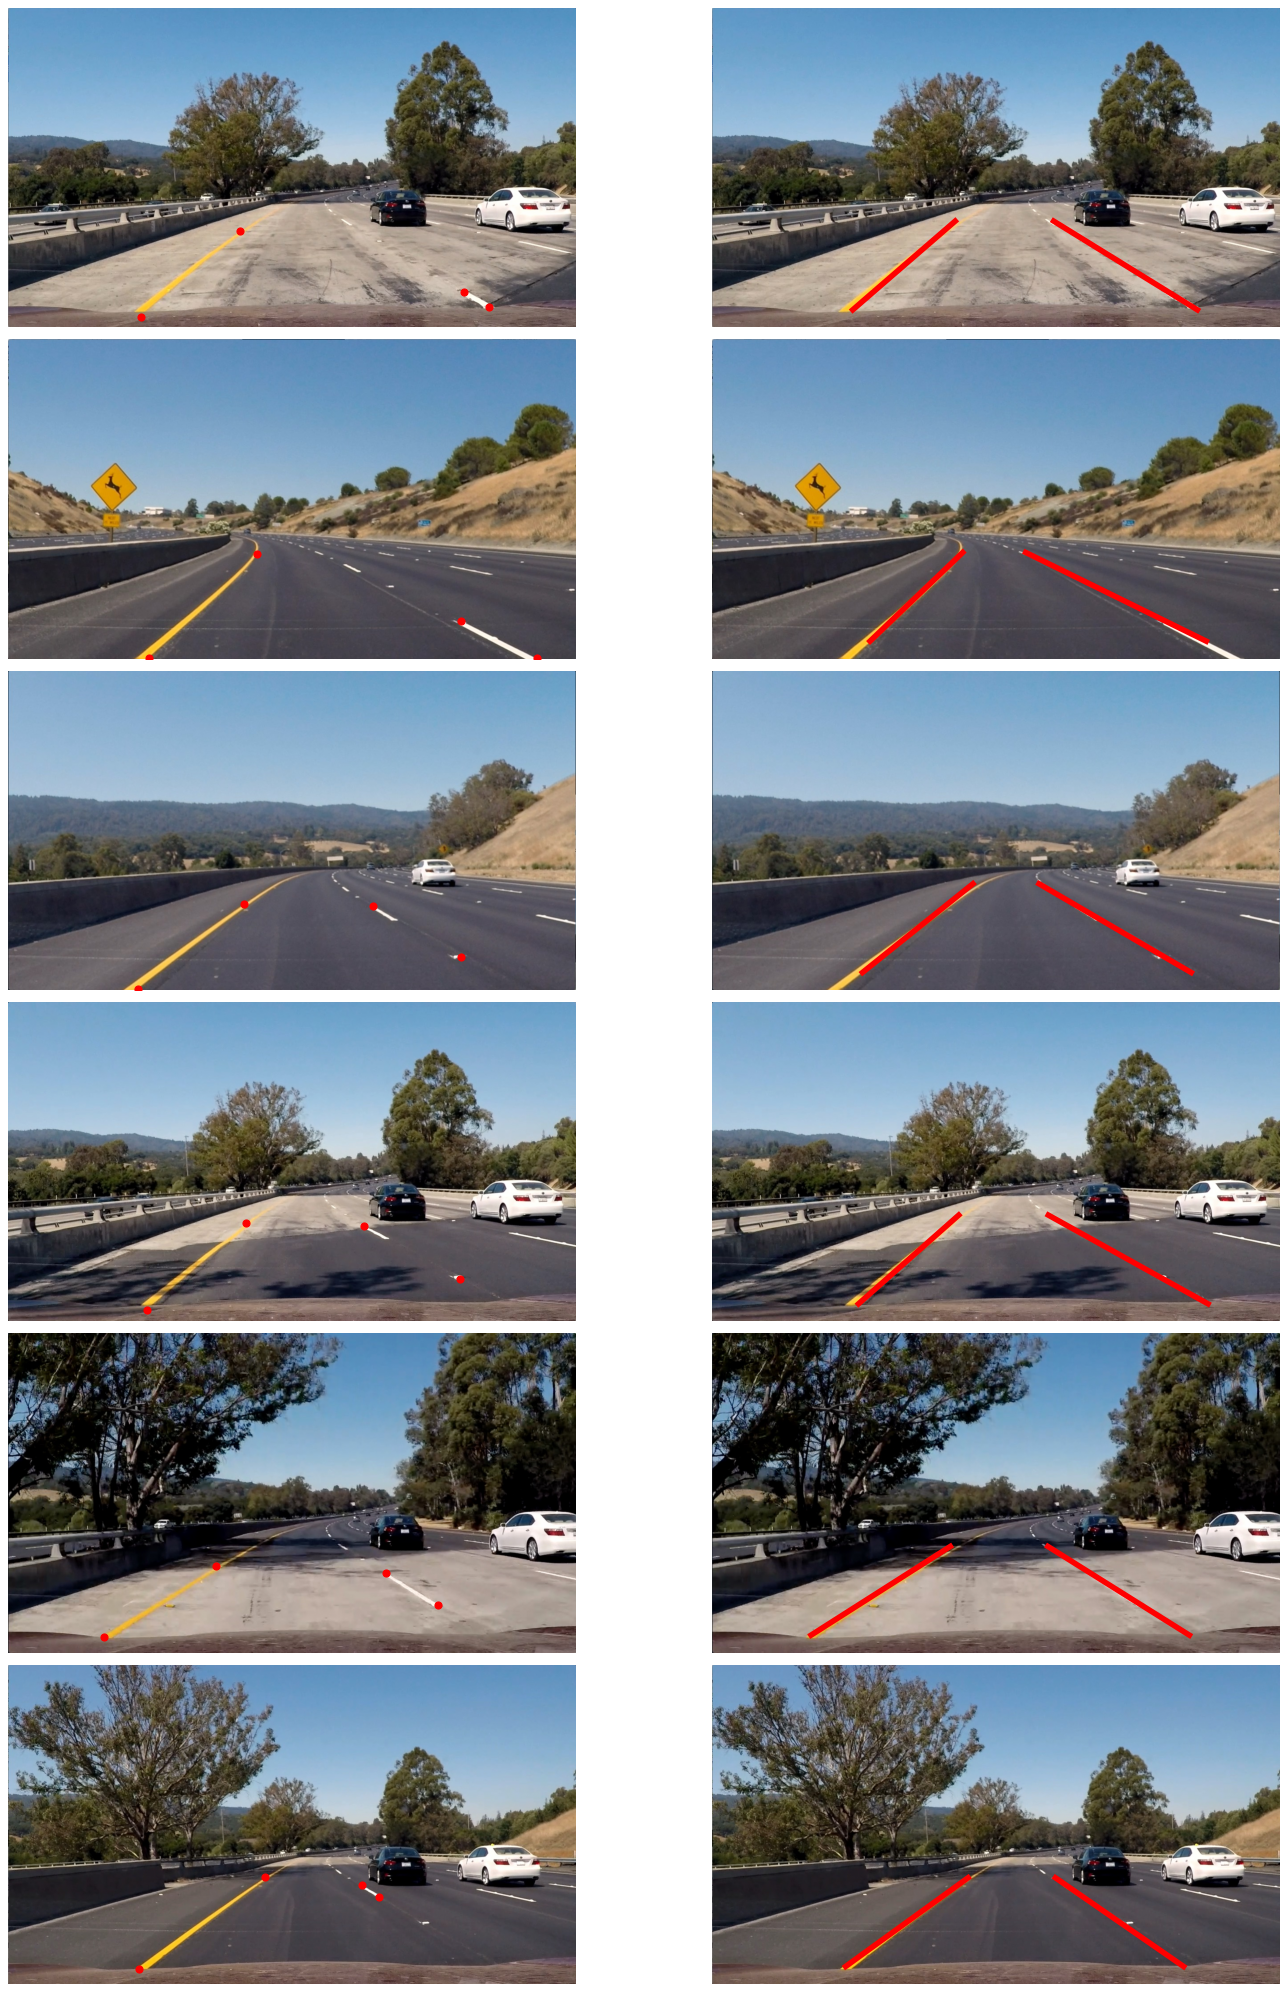

In [39]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(20,25), dpi=80)

for i in range(6):
    
    name = 'test' + str(i+1)
    image = img_as_float(imageio.imread(".\\sekvence\\" + name + '.jpg'))
    _,_,_,_,segm_image = segment_lanes(image)
    dots_r, dots_l = lane_detection(image)
    dots_r_vector = np.array(dots_r[0])
    dots_l_vector = np.array(dots_l[0])
    r_y1 = dots_r_vector[0,1]
    r_x1 = dots_r_vector[0,0]
    r_y2 = dots_r_vector[1,1]
    r_x2 = dots_r_vector[1,0]

    l_y1 = dots_l_vector[0,1]
    l_x1 = dots_l_vector[0,0]
    l_y2 = dots_l_vector[1,1]
    l_x2 = dots_l_vector[1,0]
        
    axes[i,0].imshow(image, vmin=0, vmax=1, cmap='jet'); axes[i,0].set_axis_off();
    axes[i,0].scatter(x=[r_x1,r_x2,l_x1,l_x2],y=[r_y1,r_y2,l_y1,l_y2], c='r', s=40)
 
    y_down = 680
    y_up = 480
    k_right = (r_x2 - r_x1)/(r_y2 - r_y1)
    n_right = r_x2 - k_right * r_y2
    x_down_right = int(y_down*k_right + n_right)
    x_up_right = int(y_up*k_right + n_right)
    
    k_left = (l_x2 - l_x1)/(l_y2 - l_y1)
    n_left = l_x2 - k_left * l_y2
    x_down_left = int(y_down*k_left + n_left)
    x_up_left = int(y_up*k_left + n_left)

    axes[i,1].imshow(image, vmin=0, vmax=1, cmap='gray'); axes[i,1].set_axis_off();
    axes[i,1].add_line(plt.Line2D(xdata = (x_down_right, x_up_right), ydata = (y_down,y_up), linewidth = 5, color = 'r'))
    axes[i,1].add_line(plt.Line2D(xdata = (x_down_left, x_up_left), ydata = (y_down,y_up), linewidth = 5, color = 'r'))
    
plt.tight_layout()
plt.show()

### Prikazani su test primeri sa detektovanim tackama i iscrtanim linijama preko slika. 

In [ ]:
"""
# KOD ZA VIDEO 

input_video = skvideo.io.vread("sekvence/video_road.mp4")
new_video = input_video.copy() 

for i in range(0,1260):
    dots_r, dots_l = lane_detection(new_video[i])
    dots_r_vector = np.array(dots_r[0])
    dots_l_vector = np.array(dots_l[0])
    r_y1 = dots_r_vector[0,1]
    r_x1 = dots_r_vector[0,0]
    r_y2 = dots_r_vector[1,1]
    r_x2 = dots_r_vector[1,0]

    l_y1 = dots_l_vector[0,1]
    l_x1 = dots_l_vector[0,0]
    l_y2 = dots_l_vector[1,1]
    l_x2 = dots_l_vector[1,0]

    y_down = 680
    y_up = 480
    
    k_right = (r_x2 - r_x1)/(r_y2 - r_y1)
    n_right = r_x2 - k_right * r_y2
    x_down_right = int(y_down*k_right + n_right)
    x_up_right = int(y_up*k_right + n_right)
    
    k_left = (l_x2 - l_x1)/(l_y2 - l_y1)
    n_left = l_x2 - k_left * l_y2
    x_down_left = int(y_down*k_left + n_left)
    x_up_left = int(y_up*k_left + n_left)
    
    cv2.line(new_video[i],(x_down_right, y_down),(x_up_right, y_up),(255,0,0),13) 
    cv2.line(new_video[i],(x_down_left, y_down),(x_up_left, y_up),(255,0,0),13)
    
imageio.mimwrite(os.getcwd() + '\\sekvence\\out_video_17_0017.mp4', new_video, fps=25.0)

"""